# Neural Style Transfer
Neural style transfer is an optimization technique used to take two images—a content image and a style reference image (such as an artwork by a famous painter)—and blend them together so the output image looks like the content image, but “painted” in the style of the style reference image. 

This technique is outlined in <a href="https://arxiv.org/abs/1508.06576" class="external">A Neural Algorithm of Artistic Style</a> (Gatys et al.).

This is implemented by optimizing the output image to match the content statistics of the content image and the style statistics of the style reference image. 

In this notebook, deep learning is used to create a new image version of the primary image (content image) while using the style of the secondary image (style image).

**Step 1:** Connect your google drive with this colab notebook by running the block below. You will have to give permission to connect by choosing the following options:


Connect to google drive -> Select your google account on which this colab notebook is saved -> click on "Allow"


In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


**Step 2:** Import necessary libraries and supplementary files required by running the block below. Make sure that you have the 2 files: 'image_preprocess_functions.py' and 'neural_model.py' inside the same folder as your colab notebook.

To get the path of the files, you can simply:
1. Locate the file by clicking on the "folder" icon on the left section of your colab notebook.
2. To locate it, select drive -> MyDrive -> "your location of the notebook", till you see the name of your notebook in the format "your_notebook_name.ipynb".
3. To access the path, hover over your colab notebook name inside the branches, click on the 3 dots that appear on the right side of the name -> Select "Copy path".
4. Paste the path inside the following line: 

    sys.path.append(os.path.abspath("your_path"))

In [3]:
import os
import tensorflow as tf
# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

import numpy as np
import PIL.Image
import time
import functools
import time

import sys
#The 2 files 'image_preprocess_functions.py' and 'neural_model.py' should be inside the path "your_path" (my path: /content/drive/MyDrive/AR2IL/Colab_Transfer)
#This is the same address as that for this colab notebook in this case.
sys.path.append(os.path.abspath("/content/drive/MyDrive/AR2IL/Colab_Transfer")) #"your_path"
import image_preprocess_functions as ip
import neural_model as nm

**Step 3:** Choose a style image and a content image and download them. Upload the images to your google drive (same google drive which has your colab notebook file) and copy the path of the images using the same procedure as the above. 

1. Copy the path of the content image on the 1st line below.
2. Copy the path of the style image on the 2nd line below.

In [39]:
content_path = "/content/drive/MyDrive/AR2IL/Images/YellowLabradorLooking_new.jpeg"
style_path = "/content/drive/MyDrive/AR2IL/Images/starry_night_van_gogh.jpeg"

##Visualize the input

**Step 4:** Using the load_img and imshow functions from the image_preprocess_functions.py (ip) file to display the content and style images.

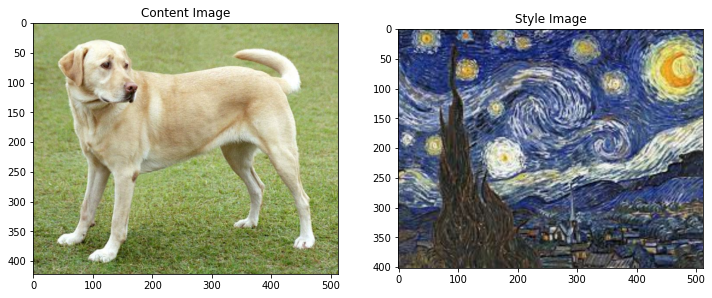

In [40]:
content_image = ip.load_img(content_path)
style_image = ip.load_img(style_path)

plt.subplot(1, 2, 1)
ip.imshow(content_image, 'Content Image')

plt.subplot(1, 2, 2)
ip.imshow(style_image, 'Style Image')

**Step 5:** Creating the neural network model with only the desired layers. Choosing layers for the content and style images separately.

In [41]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']
                
num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

extractor = nm.StyleContentModel(style_layers, content_layers)
style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

**Step 6:** Creating the model and extracting the style and content.

In [42]:
style_extractor = nm.vgg_layers(style_layers)
style_outputs = style_extractor(style_image*255)
extractor = nm.StyleContentModel(style_layers, content_layers)
results = extractor(tf.constant(content_image))

style_targets = extractor(style_image)['style']
content_targets = extractor(content_image)['content']

image = tf.Variable(content_image)

**Step 7:** Defining the loss function that is to be reduced.

In [43]:
def style_content_loss(outputs):
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    loss = style_loss + content_loss
    return loss

**Step 8:** Defining the optimizer and weighting parameters. Experiment with the following parameters to improve the output:

```
style_weight, content_weight, total_variation_weight
```







In [44]:
#Optimizer used is Adam
opt = tf.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)

#Use a weighted combination of the two losses to get the total loss
style_weight=1e-2
content_weight=1e4
total_variation_weight=30

@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)
    loss += total_variation_weight*tf.image.total_variation(image)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(ip.clip_0_1(image))

#Use tf.GradientTape to update the image.
@tf.function()
def train_step(image):
  with tf.GradientTape() as tape:
    outputs = extractor(image)
    loss = style_content_loss(outputs)

  grad = tape.gradient(loss, image)
  opt.apply_gradients([(grad, image)])
  image.assign(ip.clip_0_1(image))

The `train_step` function defines each iteration of the program and the weights update based on the gradient w.r.t the loss defined in `style_content_loss`

**Step 9**: Now run a few steps to test. We test the neural network on a few steps first before proceeding for more steps as it is way quicker to get a result as compared to for more number of steps.

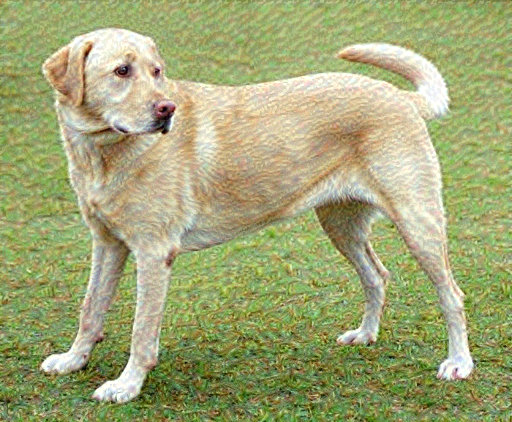

In [45]:
train_step(image)
train_step(image)
train_step(image)
ip.tensor_to_image(image)

**Step 10**: If your neural network is working above, perform a longer optimization by taking more number of steps:


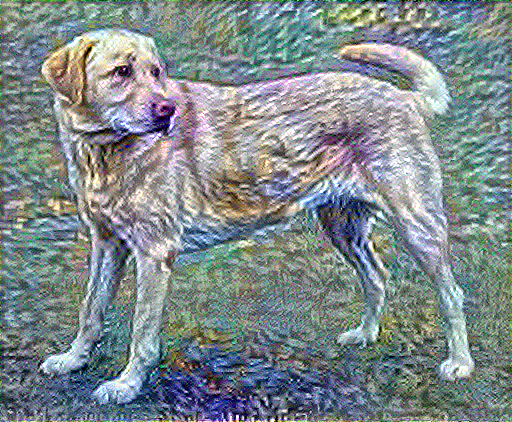

Train step: 100
Total time: 694.7


In [47]:
start = time.time()

epochs = 10
steps_per_epoch = 10

step = 0
for n in range(epochs):
  for m in range(steps_per_epoch):
    step += 1
    train_step(image)
    print(".", end='', flush=True)
  display.clear_output(wait=True)
  display.display(ip.tensor_to_image(image))
  print("Train step: {}".format(step))

end = time.time()
print("Total time: {:.1f}".format(end-start))

Saves the file to the location specified by the variable `file_name`. Make a "Results" folder and copy paste its path in `file_name` or wherever you want your result image to be saved.

In [48]:
file_name = '/content/drive/MyDrive/AR2IL/Results/stylized-image.png'
ip.tensor_to_image(image).save(file_name)

try:
  from google.colab import files
except ImportError:
   pass
else:
  files.download(file_name)

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>